<a href="https://colab.research.google.com/github/ajaysaikiran2208/MLCONCEPTS/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Wisconsin Diagnostic Breast Cancer (WDBC)

Number of instances: #569 

Number of attributes: 32 (ID, diagnosis, 30 real-valued input features)

Attribute information

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)

Several of the papers listed above contain detailed descriptions of
how these features are computed. 

The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.
Missing attribute values: none

Class distribution: 357 benign, 212 malignant

Results:

	- predicting field 2, diagnosis: B = benign, M = malignant
	- sets are linearly separable using all 30 input features
	- best predictive accuracy obtained using one separating plane
		in the 3-D space of Worst Area, Worst Smoothness and
		Mean Texture.  Estimated accuracy 97.5% using repeated
		10-fold crossvalidations.  Classifier has correctly
		diagnosed 176 consecutive new patients as of November
		1995. 

In [1]:
!pip install catboost

     |████████████████████████████████| 69.2MB 53kB/s 


In [37]:
import pandas as pd
import numpy as np
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from IPython.display import display
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")


In [7]:
df_test = pd.read_csv("/content/Test_LqhgPWU.csv")
df_train=pd.read_csv("/content/Train_aBjfeNk.csv")

In [8]:
df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [6]:
train.info

<bound method DataFrame.info of           ID  Gender Ever_Married  ...  Family_Size  Var_1 Segmentation
0     462809    Male           No  ...          4.0  Cat_4            D
1     462643  Female          Yes  ...          3.0  Cat_4            A
2     466315  Female          Yes  ...          1.0  Cat_6            B
3     461735    Male          Yes  ...          2.0  Cat_6            B
4     462669  Female          Yes  ...          6.0  Cat_6            A
...      ...     ...          ...  ...          ...    ...          ...
8063  464018    Male           No  ...          7.0  Cat_1            D
8064  464685    Male           No  ...          4.0  Cat_4            D
8065  465406  Female           No  ...          1.0  Cat_6            D
8066  467299  Female           No  ...          4.0  Cat_6            B
8067  461879    Male          Yes  ...          3.0  Cat_4            B

[8068 rows x 11 columns]>

In [12]:
# Convert Numeric NaNs to -999
features = ["Age", "Work_Experience", "Family_Size"]
df_train[features] = df_train[features].fillna(-999)
df_test[features] = df_test[features].fillna(-999)

In [13]:
# NaN in gender could mean that person is a transgender and does not want to disclose
gender_mapping = {"Male": 0, "Female": 1}
df_train["Gender"] = df_train["Gender"].fillna(2)
df_test["Gender"] = df_test["Gender"].fillna(2)
for gender, label in gender_mapping.items():
    df_train["Gender"] = df_train["Gender"].replace(gender, label)
    df_test["Gender"] = df_test["Gender"].replace(gender, label)

# Nan in ever_married could mean that the person does not want to reveal
# In that case it gives us extra info about the person type
married_mapping = {"Yes": 0, "No": 1}
df_train["Ever_Married"] = df_train["Ever_Married"].fillna(2)
df_test["Ever_Married"] = df_test["Ever_Married"].fillna(2)
for married, label in married_mapping.items():
    df_train["Ever_Married"] = df_train["Ever_Married"].replace(married, label)
    df_test["Ever_Married"] = df_test["Ever_Married"].replace(married, label)
    
# Nan in graduated could mean that the person has not graduate and does not want to reveal
grad_mapping = {"Yes": 0, "No": 1}
df_train["Graduated"] = df_train["Graduated"].fillna(1)
df_test["Graduated"] = df_test["Graduated"].fillna(1)
for grad, label in grad_mapping.items():
    df_train["Graduated"] = df_train["Graduated"].replace(grad, label)
    df_test["Graduated"] = df_test["Graduated"].replace(grad, label)

# Nan in profession could mean that person is unemployed
prof_mapping = {"Artist": 0, "Doctor": 1, "Engineer": 2, "Entertainment": 3, "Executive": 4, "Healthcare": 5, "Homemaker": 6, "Lawyer": 7, "Marketing": 8}
df_train["Profession"] = df_train["Profession"].fillna(9)
df_test["Profession"] = df_test["Profession"].fillna(9)
for prof, label in prof_mapping.items():
    df_train["Profession"] = df_train["Profession"].replace(prof, label)
    df_test["Profession"] = df_test["Profession"].replace(prof, label)

# Spending score is nan means it could be low
ss_mapping = {"Low": 0, "Average": 1, "High": 2}
df_train["Spending_Score"] = df_train["Spending_Score"].fillna(ss_mapping["Low"])
df_test["Spending_Score"] = df_test["Spending_Score"].fillna(ss_mapping["Low"])
for ss, label in ss_mapping.items():
    df_train["Spending_Score"] = df_train["Spending_Score"].replace(ss, label)
    df_test["Spending_Score"] = df_test["Spending_Score"].replace(ss, label)

# NaN in Var1 is just another category
var1_mapping = {"Cat_1": 0, "Cat_2": 1, "Cat_3": 2, "Cat_4": 3, "Cat_5": 4, "Cat_6": 5, "Cat_7": 6}
df_train["Var_1"] = df_train["Var_1"].fillna(7)
df_test["Var_1"] = df_test["Var_1"].fillna(7)
for var1, label in var1_mapping.items():
    df_train["Var_1"] = df_train["Var_1"].replace(var1, label)
    df_test["Var_1"] = df_test["Var_1"].replace(var1, label)

# Finally label encode segmentation
seg_mapping = {"A": 0, "B": 1, "C": 2, "D": 3}
seg_mapping_rev = {0: "A", 1: "B", 2: "C", 3: "D"}
for seg, label in seg_mapping.items():
    df_train["Segmentation"] = df_train["Segmentation"].replace(seg, label)

# Based on EDA, bin the Age feature (Didn't help)
# 1 -> young, 2 -> middle-aged, 3 -> old, 4 -> retired and old
df_train["Age_group"] = [1 if i<=33 else 2 if i>33 and i<65 else 3 if i>=65 and i<74 else 4 for i in df_train["Age"].values]
df_test["Age_group"] = [1 if i<=33 else 2 if i>33 and i<65 else 3 if i>=65 and i<74 else 4 for i in df_test["Age"].values]

# Based on EDA, Create Lonely feature :P
df_train["Lonely"] = [1 if members<2 and age >= 60 and gender == 1 else 0 for members, age, gender in zip(df_train["Family_Size"].values, df_train["Age"].values, df_train["Gender"].values)]
df_test["Lonely"] = [1 if members<2 and age >= 60 and gender == 1 else 0 for members, age, gender in zip(df_test["Family_Size"].values, df_test["Age"].values, df_test["Gender"].values)]

# Bin the ID column and add as feature
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
df_train["Binned_ID"] = est.fit_transform(np.reshape(df_train["ID"].values, (-1,1)))
df_test["Binned_ID"] = est.transform(np.reshape(df_test["ID"].values, (-1,1)))

df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_group,Lonely,Binned_ID
0,462809,0,1,22,1,5,1.0,0,4.0,3,3,1,0,4.0
1,462643,1,0,38,0,2,-999.0,1,3.0,3,0,2,0,4.0
2,466315,1,0,67,0,2,1.0,0,1.0,5,1,3,1,8.0
3,461735,0,0,67,0,7,0.0,2,2.0,5,1,3,0,3.0
4,462669,1,0,40,0,3,-999.0,2,6.0,5,0,2,0,4.0


In [14]:

# Drop the columns specified
cols_to_remove = ["ID", "Segmentation"]
df_train_dum, Y = df_train.drop(cols_to_remove, axis=1), df_train[cols_to_remove[-1]].values
df_test_dum = df_test.drop(cols_to_remove[:-1], axis=1)

# Specify which features are to be treated as Categorical features
cat_feats = ['Gender', 'Ever_Married', 'Graduated', "Var_1", 'Profession', 'Age_group', 'Lonely', "Binned_ID"]
cat_feats_inds = [df_train_dum.columns.get_loc(c) for c in cat_feats]

In [19]:
# The usual
outer_kfold = KFold(n_splits=5, random_state=27, shuffle=True)
final_scores = list()
for train, test in outer_kfold.split(df_train_dum):
    X_train, X_test = df_train_dum.iloc[train].values, df_train_dum.iloc[test].values
    y_train, y_test = Y[train], Y[test]
    
    model = XGBClassifier(random_state=27, eval_metric="logloss", max_depth=3, n_estimators=82)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    final_scores.append(accuracy_score(y_test, preds))
    print("Score:", final_scores[-1])
print("\nAverage Score:", np.average(final_scores))

Score: 0.5359355638166047
Score: 0.5272614622057001
Score: 0.547087980173482
Score: 0.5201487910725356
Score: 0.5251084934903906

Average Score: 0.5311084581517427


#Logistic Regression

In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
conf = confusion_matrix(y_test, y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

#convert into binary values 0/1 for classification
for i in range(0, X_test.shape[0]):
    if y_pred_lr[i]>=.5:       # setting threshold to .5
       y_pred_lr[i]=1
    else:  
       y_pred_lr[i]=0

Accuracy Score of Logistic Regression is : 0.4463732176069436
Confusion Matrix : 
[[106  24 140 111]
 [ 79  35 189  68]
 [ 38  28 262  66]
 [ 96   8  46 317]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.33      0.28      0.30       381
           1       0.37      0.09      0.15       371
           2       0.41      0.66      0.51       394
           3       0.56      0.68      0.62       467

    accuracy                           0.45      1613
   macro avg       0.42      0.43      0.39      1613
weighted avg       0.43      0.45      0.41      1613



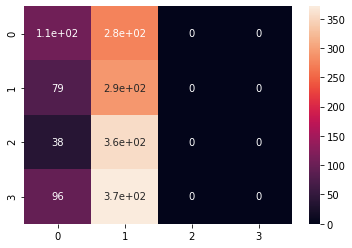

In [18]:
#Confusion matrix

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True)

#KNN

In [20]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
conf = confusion_matrix(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")
#convert into binary values 0/1 for classification
for i in range(0, X_test.shape[0]):
    if y_pred_knn[i]>=.5:       # setting threshold to .5
       y_pred_knn[i]=1
    else:  
       y_pred_knn[i]=0

Accuracy Score of KNN is : 0.44699318040917546
Confusion Matrix : 
[[172  86  60  63]
 [120 108  97  46]
 [ 83  96 171  44]
 [114  45  38 270]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.35      0.45      0.40       381
           1       0.32      0.29      0.31       371
           2       0.47      0.43      0.45       394
           3       0.64      0.58      0.61       467

    accuracy                           0.45      1613
   macro avg       0.44      0.44      0.44      1613
weighted avg       0.46      0.45      0.45      1613



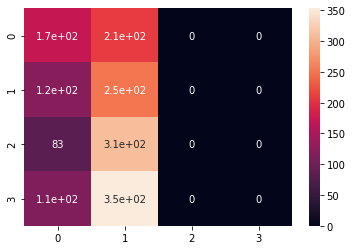

In [21]:
#Confusion matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True)

#Decision Tree Classifier

In [22]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")
#convert into binary values 0/1 for classification
for i in range(0, X_test.shape[0]):
    if y_pred_dtc[i]>=.5:       # setting threshold to .5
       y_pred_dtc[i]=1
    else:  
       y_pred_dtc[i]=0

Accuracy Score of Decision Tree is : 0.4190948543087415
Confusion Matrix : 
[[131 100  63  87]
 [ 94 121 108  48]
 [ 64 125 173  32]
 [ 84  71  61 251]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.35      0.34      0.35       381
           1       0.29      0.33      0.31       371
           2       0.43      0.44      0.43       394
           3       0.60      0.54      0.57       467

    accuracy                           0.42      1613
   macro avg       0.42      0.41      0.41      1613
weighted avg       0.43      0.42      0.42      1613



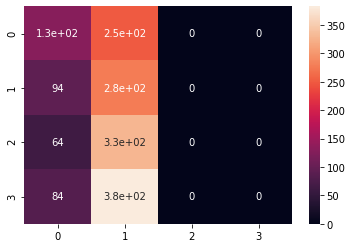

In [23]:
#Confusion matrix

cm_dtc = confusion_matrix(y_test, y_pred_dtc)
sns.heatmap(cm_dtc, annot=True)

##Random Forest Classifier

In [24]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)

y_pred_rd_clf = rd_clf.predict(X_test)

acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
conf = confusion_matrix(y_test, y_pred_rd_clf)
clf_report = classification_report(y_test, y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Random Forest is : 0.49969001859888407
Confusion Matrix : 
[[160  90  44  87]
 [ 92 120 109  50]
 [ 48  89 208  49]
 [ 98  28  23 318]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.40      0.42      0.41       381
           1       0.37      0.32      0.34       371
           2       0.54      0.53      0.53       394
           3       0.63      0.68      0.65       467

    accuracy                           0.50      1613
   macro avg       0.49      0.49      0.49      1613
weighted avg       0.49      0.50      0.50      1613



In [25]:
for i in range(0, X_test.shape[0]):
    if y_pred_rd_clf[i]>=.5:       # setting threshold to .5
       y_pred_rd_clf[i]=1
    else:  
       y_pred_rd_clf[i]=0

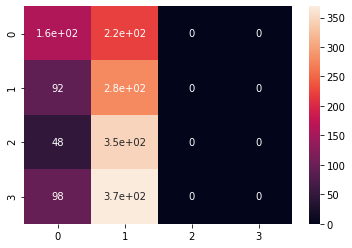

In [26]:
#Confusion matrix

cm_rd_clf = confusion_matrix(y_test, y_pred_rd_clf)
sns.heatmap(cm_rd_clf, annot=True)

#Ada Boost Classifier

In [27]:
ada = AdaBoostClassifier(base_estimator = dtc)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred_ada)
conf = confusion_matrix(y_test, y_pred_ada)
clf_report = classification_report(y_test, y_pred_ada)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_ada}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.4717916924984501
Confusion Matrix : 
[[150  92  54  85]
 [ 96 130 101  44]
 [ 47 107 188  52]
 [105  37  32 293]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.38      0.39      0.39       381
           1       0.36      0.35      0.35       371
           2       0.50      0.48      0.49       394
           3       0.62      0.63      0.62       467

    accuracy                           0.47      1613
   macro avg       0.46      0.46      0.46      1613
weighted avg       0.47      0.47      0.47      1613



In [28]:
for i in range(0, X_test.shape[0]):
    if y_pred_ada[i]>=.5:       # setting threshold to .5
       y_pred_ada[i]=1
    else:  
       y_pred_ada[i]=0

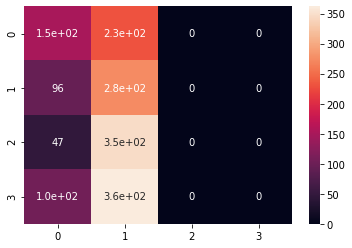

In [29]:
#Confusion matrix

cm_rd_ada = confusion_matrix(y_test, y_pred_ada)
sns.heatmap(cm_rd_ada, annot=True)

#Gradient Boosting Classifier

In [30]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
conf = confusion_matrix(y_test, y_pred_gb)
clf_report = classification_report(y_test, y_pred_gb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_gb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.5238685678859268
Confusion Matrix : 
[[189  82  38  72]
 [113 101 109  48]
 [ 45  76 218  55]
 [ 95  26   9 337]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.43      0.50      0.46       381
           1       0.35      0.27      0.31       371
           2       0.58      0.55      0.57       394
           3       0.66      0.72      0.69       467

    accuracy                           0.52      1613
   macro avg       0.51      0.51      0.51      1613
weighted avg       0.52      0.52      0.52      1613



In [31]:
for i in range(0, X_test.shape[0]):
    if y_pred_gb[i]>=.5:       # setting threshold to .5
       y_pred_gb[i]=1
    else:  
       y_pred_gb[i]=0

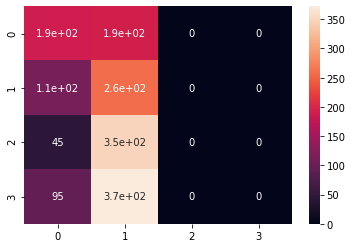

In [32]:
#Confusion matrix

cm_rd_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_rd_gb, annot=True)

##XGBOOST

In [59]:
 model = XGBClassifier(random_state=27, eval_metric="logloss", max_depth=3, n_estimators=82)
 model.fit(X_train, y_train)
preds = model.predict(X_test)

In [69]:
acc_xgb=accuracy_score(y_test, preds)
acc_xgb


0.5251084934903906

In [ ]:
final_scores.append(accuracy_score(y_test, preds))
print("Score:", final_scores[-1])
print("\nAverage Score:", np.average(final_scores))

Accuracy with XGBoost=  0.5251084934903906


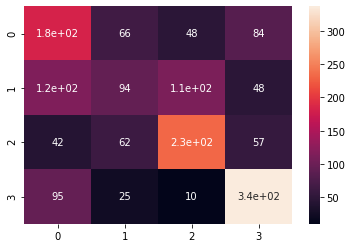

In [64]:
cm_xgb = confusion_matrix(y_test, preds)
sns.heatmap(cm_xgb, annot=True)

print ("Accuracy with XGBoost= ", metrics.accuracy_score(preds, y_test))


#Cat Boost Classifier

In [44]:
cat = CatBoostClassifier(iterations=100)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)
print(f"Accuracy Score of Ada Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Learning rate set to 0.5
0:	learn: 1.1754044	total: 52.4ms	remaining: 5.19s
1:	learn: 1.1103612	total: 58.1ms	remaining: 2.85s
2:	learn: 1.0850798	total: 63.2ms	remaining: 2.04s
3:	learn: 1.0627757	total: 68.2ms	remaining: 1.64s
4:	learn: 1.0500189	total: 73.1ms	remaining: 1.39s
5:	learn: 1.0397407	total: 78.1ms	remaining: 1.22s
6:	learn: 1.0342881	total: 82.6ms	remaining: 1.1s
7:	learn: 1.0295539	total: 87.2ms	remaining: 1s
8:	learn: 1.0221959	total: 92ms	remaining: 930ms
9:	learn: 1.0136861	total: 96.6ms	remaining: 870ms
10:	learn: 1.0080778	total: 101ms	remaining: 819ms
11:	learn: 1.0048449	total: 106ms	remaining: 776ms
12:	learn: 0.9960834	total: 110ms	remaining: 739ms
13:	learn: 0.9894822	total: 115ms	remaining: 708ms
14:	learn: 0.9843969	total: 120ms	remaining: 681ms
15:	learn: 0.9804071	total: 125ms	remaining: 655ms
16:	learn: 0.9759648	total: 129ms	remaining: 632ms
17:	learn: 0.9729054	total: 134ms	remaining: 611ms
18:	learn: 0.9650725	total: 139ms	remaining: 593ms
19:	learn: 0

In [45]:
#Converting probabilities into 1 or 0  
for i in range(0, X_test.shape[0]): 
    if y_pred_cat[i]>=.5:       # setting threshold to .5 
       y_pred_cat[i]=1 
    else: 
       y_pred_cat[i]=0 

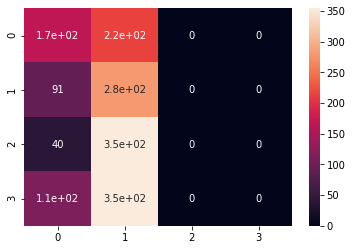

In [46]:
#Confusion Matrix
cm_cat = confusion_matrix(y_test, y_pred_cat)
sns.heatmap(cm_cat, annot=True)



#Extra Trees Classifier

In [47]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

y_pred_etc = etc.predict(X_test)

acc_etc = accuracy_score(y_test, y_pred_etc)
conf = confusion_matrix(y_test, y_pred_etc)
clf_report = classification_report(y_test, y_pred_etc)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_etc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.4841909485430874
Confusion Matrix : 
[[165  89  38  89]
 [ 96 124 107  44]
 [ 49  98 196  51]
 [104  33  34 296]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.40      0.43      0.42       381
           1       0.36      0.33      0.35       371
           2       0.52      0.50      0.51       394
           3       0.62      0.63      0.63       467

    accuracy                           0.48      1613
   macro avg       0.47      0.47      0.47      1613
weighted avg       0.48      0.48      0.48      1613



In [48]:
#Converting probabilities into 1 or 0  
for i in range(0, X_test.shape[0]): 
    if y_pred_etc[i]>=.5:       # setting threshold to .5 
       y_pred_etc[i]=1 
    else: 
       y_pred_etc[i]=0 

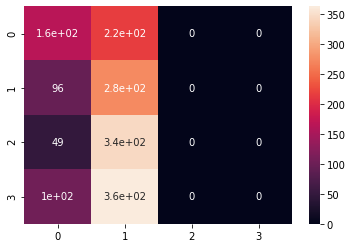

In [49]:
#Confusion Matrix
cm_etc = confusion_matrix(y_test, y_pred_etc)
sns.heatmap(cm_etc, annot=True)


#LGBM Classifier

In [50]:
lgbm = LGBMClassifier(learning_rate = 1)
lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)

acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
conf = confusion_matrix(y_test, y_pred_lgbm)
clf_report = classification_report(y_test, y_pred_lgbm)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_lgbm}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.486050836949783
Confusion Matrix : 
[[157  92  47  85]
 [ 91 125 112  43]
 [ 53 100 197  44]
 [ 84  41  37 305]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.41      0.41      0.41       381
           1       0.35      0.34      0.34       371
           2       0.50      0.50      0.50       394
           3       0.64      0.65      0.65       467

    accuracy                           0.49      1613
   macro avg       0.47      0.48      0.47      1613
weighted avg       0.48      0.49      0.49      1613



In [51]:
#Converting probabilities into 1 or 0  
for i in range(0, X_test.shape[0]): 
    if y_pred_lgbm[i]>=.5:       # setting threshold to .5 
       y_pred_lgbm[i]=1 
    else: 
       y_pred_lgbm[i]=0 

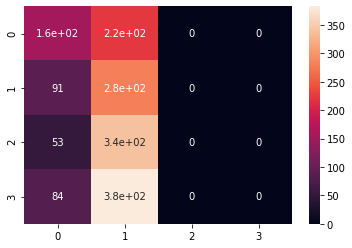

In [52]:
#Confusion Matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True)

In [70]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'XGBOOST','Gradient Boosting Classifier','Cat Boost', 'Extra Trees Classifier', 'LGBM'],
    'Score' : [acc_lr, acc_knn, acc_dtc, acc_rd_clf, acc_ada,acc_xgb,acc_gb, acc_cat, acc_etc, acc_lgbm]
})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
5,XGBOOST,0.525108
6,Gradient Boosting Classifier,0.525108
7,Cat Boost,0.508989
3,Random Forest Classifier,0.499690
9,LGBM,0.486051
8,Extra Trees Classifier,0.484191
4,Ada Boost Classifier,0.471792
1,KNN,0.446993
0,Logistic Regression,0.446373
2,Decision Tree Classifier,0.419095
